<a href="https://colab.research.google.com/github/NitheshNayak/COVID-19-chest-X-ray-analysis/blob/main/Notebook_COVID_19_Chest_X_ray_Analysis_Group_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COVID-19 Chest X-ray Analysis
    By, 
        Tamara Orth
        Joshua Baudin 
        Nithesh Nayak 

In [1]:
# # connect to local working directory on Google Colab - This cell block has to be commented if not using google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# add my working directory to the Notebook path
import sys
WORKSPACE = "/content/drive/My Drive/MyFiles/IFN646/COVID-19 Radiography Database/" # download kaggle dataset and use the folder path - https://www.kaggle.com/tawsifurrahman/covid19-radiography-database
sys.path.append(WORKSPACE)

In [3]:
#Importing Libraries
import os #python - 3.8.5

import cv2 #Importing openCV-2  : cv2 - 4.0.1
        
#Basic Python Libraries 
import numpy as np # numpy - 1.18.5
import pandas as pd #pandas - 1.1.1

#Visualization Libraries 
import seaborn as sns # Version - seaborn - 0.11.0
import matplotlib.pyplot as plt  # Version - matplotlib - 3.3.1

#sklearn 
import sklearn.metrics as metrics # Version - sklearn - 0.23.2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

#Keras
from keras.utils import np_utils # Version - keras - 2.4.3

#TensorFlow
from tensorflow.keras.models import Model # Version -tensorflow - 2.3.0
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import  VGG19
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

In [4]:
# Obtain list of image paths. Last line is to verify number of image paths obtained matches number of expected images for our dataset.

filePaths = []
#Fetching filenames from the data directory
for directory, _, ImageFilenames in os.walk(WORKSPACE):
    for ImageName in ImageFilenames:
        if (ImageName[-3:] == 'png'):
            filePaths.append(os.path.join(directory, ImageName))

#Check whether all the images are imported from actual 
if len(filePaths) == 219+1341+1345:
    print("All Files are imported")
else:
    print("Error ! Some Files are missing !!!")
print(len(filePaths))

All Files are imported
2905


/content/drive/My Drive/MyFiles/IFN646/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (303).png
(1024, 1024, 3)


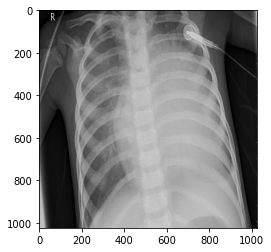

/content/drive/My Drive/MyFiles/IFN646/COVID-19 Radiography Database/COVID-19/COVID-19 (42).png
(1024, 1024, 3)


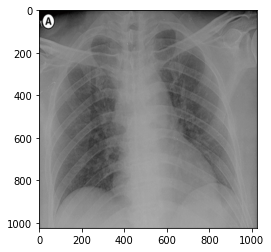

/content/drive/My Drive/MyFiles/IFN646/COVID-19 Radiography Database/NORMAL/NORMAL (996).png
(1024, 1024, 3)


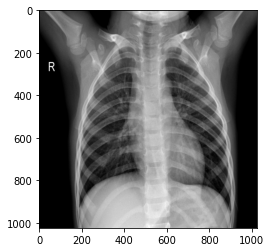

In [5]:
# View a sample image in the dataSet
def SampleImage (fileName):
    print(filePaths[fileName])
    imageSample = cv2.imread(filePaths[fileName])
    print(imageSample.shape)
    plt.imshow(imageSample)
    plt.show()

SampleImage(455) #Normal
SampleImage(55) # COVID-19

SampleImage(2555) #Viral Pneumonia

In [ ]:
# Creating an array containing image label and data from the above created list

ImageData = [] ; ImageLabel = []
IMG_SIZE = 224 #Image Size

print("Code block Running ..")
for file_path in filePaths:
    label = file_path.split(os.path.sep)[-2]
    
#     image = cv2.imread(file_path)
    image = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
    #Resizing the image to 224 x 224 resolution and the normalizing the image pixel to by diving 255  
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))/255.0 
    
    ImageData.append(image) #Store resized and Normalised Image into a list 
    ImageLabel.append(label)

X = np.array(ImageData)
y = np.array(ImageLabel)
print("Code block completed ..")

print("Shape of the entire image array -",X.shape)
print("Size of Label array - ", y.shape)

Code block Running ..


In [ ]:
#Summary of all the three class of images
yy =y.copy()

y_df = pd.DataFrame(y, columns=['Labels'])

ClassCount_df=y_df['Labels'].value_counts()

ClassCount_df_02=pd.DataFrame(ClassCount_df).reset_index()


ClassCount_df_02=ClassCount_df_02.rename(columns={"index": "Class"})


ClassCount_df_02['Class'] = ClassCount_df_02['Class'].str.replace('COVID-19 Radiography Database/', '')

print(ClassCount_df_02)

# Pie chart distribution all the three classes in the dataset
labels = ClassCount_df_02['Class'] ; sizes = ClassCount_df_02['Labels']

explode = (0, 0, 0.2)  # Explode only 2nd SLice i.e. COVID-19

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()


In [ ]:
# One-Hot encoding for all the three classes 

le = LabelEncoder()
y_encoded = le.fit_transform(y)

#Converting to one hot encoding 
y_encoded = np_utils.to_categorical(y_encoded)
print("Total Files converted - ", len(y_encoded))
# print(y_encoded, '\n')

In [ ]:
#Splitting the data into Train and test using Stratified Sampling since all the class data is not uniformaly distributed

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.30,  random_state=43, stratify=y_encoded)

print("Number of Training Images and its Dimention  - ", X_train.shape) 

# (m,nx,ny,nz) where m - Number of samples | nx,ny is the resolution of the image and nz is number of layer of image (i.e. now R,G,B) 

print("Number of Test Images and its Dimention - ", X_test.shape)

In [ ]:
#Data augmentation : To increase the number of images, augmenting the present images to expand the dataset. 

train_aug = ImageDataGenerator(rotation_range=15)

#The lung images are some what symetrical ( since lungs are in symetry) so rather than flipping a symettric image we have tilted the image
# We have obserevd in other dataset the chest X-rays where bit tilted, so as to recrreat similar senario we have tiled the images by 15 degree's
#https://keras.io/api/preprocessing/image/

In [ ]:
#Transfer learning with VGG19 

#Since we have found through our Literature Review that VGG-19 has given promising results in the field of chest x-rays , 
# we are transfer learning from VGG19 to our sequential model with Fully Connected Layers

def Model_VGG19():
    # base_model = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

    base_model.trainable = False # Freeze the the Base model
    
    #Include_Top - We have not included the fully connected layer at the top 
    #Weights = We have Used pretrained weights from the famous Imagenet Model here 
    #Input Shape - Shape of the image was kept same as mentioned in the previous steps
    #pooling - We have not included any pooling here - So that no global avergae pooling will be applied to last convolutional block
    
   
    output = base_model.layers[-1].output #Last layer will be our fully connected output layer
    
    output = Flatten()(output) #Since the ouput is bactch, i.e. without feature axis, Flattening the output layer adds an extra channel dimension 
    
    model = Model(base_model.input, outputs=output) #Model input and pouputs 
    
    ## Freeze all the layers
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
# Neural Transfer 
covid_XR_model = Sequential()

covid_XR_model.add(Model_VGG19()) #VGG19 model
covid_XR_model.add(Dropout(0.25))

#Adding the Dense Layers 
covid_XR_model.add(Dense(512, activation='relu'))
covid_XR_model.add(Dropout(0.25))
covid_XR_model.add(Dense(64, activation='relu'))

covid_XR_model.add(Dense(3, activation='softmax'))

covid_XR_model.summary() #There are 20M non trained parameters, which are from VGG19. Here in the transfer learning we have freezed the VGG19 model (base Model) i.e. layer1.trainable = False

In [ ]:
# Set constants and hyperparameter values:
LR = 0.0001  #Learning Rate
EPOCHS = 7
BATCH_SIZE = 32 

#instantiate the optimizer
optim = Adam(lr = LR, decay = LR/EPOCHS)

#Configure the model Losses and metrics
covid_XR_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

#Train the Model 
history = covid_XR_model.fit(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

In [ ]:
#Model Accuracy Graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Graph Labelling 
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [ ]:
#Model Loss vairation with epoches 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Variation in COVID_XR model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Testing the model 
TestResult = covid_XR_model.evaluate(X_test, y_test)
print("Model test accuracy : %f." %(TestResult[1]*100))

In [ ]:
# Confusion matrix to evaluate the model classification accuracy 

print("Predicting the labels for test data-set ... ")
y_pred = np.argmax(covid_XR_model.predict(X_test), axis=1) # Predicting results on test data set

print("Extracting actual test data-set labels ... ")
y_test_labels = np.argmax(y_test, axis=1) # Extracting actual test labels 

print("Confusion Matrix for the model")
EvaluationMatrix = confusion_matrix(y_test_labels, y_pred)
EvaluationMatrix_df = pd.DataFrame(EvaluationMatrix, index=le.classes_, columns=le.classes_)
EvaluationMatrix_df.columns =['COVID-19', 'NORMAL','Viral Pneumonia'] 
EvaluationMatrix_df.index =['COVID-19', 'NORMAL','Viral Pneumonia'] 

print(EvaluationMatrix_df.head())

#Creating the Heat Map
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(EvaluationMatrix_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='Blues')

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()



---



---



---


-----------------